In [1]:
import sys
sys.path.insert(0, '..')
import functools
import timeit
import zarr
print('zarr', zarr.__version__)
from zarr import blosc
print('blosc', blosc.version())
import numpy as np
import h5py
%matplotlib inline
import matplotlib.pyplot as plt

zarr 1.0.1.dev18+dirty
blosc ('1.10.0.dev', '$Date:: 2016-07-20 #$')


In [2]:
callset = h5py.File('/data/coluzzi/ag1000g/data/phase1/release/AR3/variation/main/hdf5/ag1000g.phase1.ar3.pass.h5',
                    mode='r')
genotype = callset['3R/calldata/genotype']
genotype

<HDF5 dataset "genotype": shape (13167162, 765, 2), type "|i1">

In [3]:
n_variants = 500000

In [4]:
genotype_sample = genotype[1000000:1000000+n_variants, ...]
genotype_sample.shape

(500000, 765, 2)

In [6]:
nbytes = genotype_sample.nbytes
nbytes

765000000

In [52]:
# 1M chunks of first dimension
chunks = (int(2**20 / (genotype_sample.shape[1] * genotype_sample.shape[2])), 
          genotype_sample.shape[1], 
          genotype_sample.shape[2])
chunks

(685, 765, 2)

In [8]:
blosc.get_nthreads()

8

In [41]:
zarr.array(genotype_sample, chunks=chunks, compression_opts=dict(cname='lz4', clevel=1, shuffle=2))

zarr.core.Array((500000, 765, 2), int8, chunks=(685, 765, 2), order=C)
  compression: blosc; compression_opts: {'clevel': 1, 'cname': 'lz4', 'shuffle': 2}
  nbytes: 729.6M; nbytes_stored: 23.0M; ratio: 31.7; initialized: 730/730
  store: builtins.dict

In [11]:
zarr.array(genotype_sample, chunks=chunks, compression_opts=dict(cname='zstd', clevel=1, shuffle=2))

zarr.core.Array((500000, 765, 2), int8, chunks=(685, 765, 2), order=C)
  compression: blosc; compression_opts: {'clevel': 1, 'cname': 'zstd', 'shuffle': 2}
  nbytes: 729.6M; nbytes_stored: 12.0M; ratio: 60.7; initialized: 730/730
  store: builtins.dict

In [42]:
compression_configs = (
    dict(cname='snappy', clevel=9, shuffle=0),
    dict(cname='snappy', clevel=9, shuffle=2),
    dict(cname='blosclz', clevel=1, shuffle=0),
    dict(cname='blosclz', clevel=5, shuffle=0),
    dict(cname='blosclz', clevel=9, shuffle=0),
    dict(cname='blosclz', clevel=1, shuffle=2),
    dict(cname='blosclz', clevel=5, shuffle=2),
    dict(cname='blosclz', clevel=9, shuffle=2),
    dict(cname='lz4', clevel=1, shuffle=0),
    dict(cname='lz4', clevel=5, shuffle=0),
    dict(cname='lz4', clevel=9, shuffle=0),
    dict(cname='lz4', clevel=1, shuffle=2),
    dict(cname='lz4', clevel=5, shuffle=2),
    dict(cname='lz4', clevel=9, shuffle=2),
    dict(cname='lz4hc', clevel=1, shuffle=0),
    dict(cname='lz4hc', clevel=3, shuffle=0),
    dict(cname='lz4hc', clevel=1, shuffle=2),
    dict(cname='lz4hc', clevel=3, shuffle=2),
    dict(cname='zstd', clevel=1, shuffle=0),
    dict(cname='zstd', clevel=3, shuffle=0),
    dict(cname='zstd', clevel=5, shuffle=0),
    dict(cname='zstd', clevel=1, shuffle=2),
    dict(cname='zstd', clevel=3, shuffle=2),
    dict(cname='zstd', clevel=5, shuffle=2),
    dict(cname='zlib', clevel=1, shuffle=0),
    dict(cname='zlib', clevel=3, shuffle=0),
    dict(cname='zlib', clevel=5, shuffle=0),
    dict(cname='zlib', clevel=1, shuffle=2),
    dict(cname='zlib', clevel=3, shuffle=2),
    dict(cname='zlib', clevel=5, shuffle=2),
)

In [43]:
def log(*msg):
    print(*msg, file=sys.stdout)
    sys.stdout.flush()

In [44]:
@functools.lru_cache(maxsize=None)
def compression_ratios():
    x = list()
    for compression_opts in compression_configs:
        z = zarr.array(genotype_sample, chunks=chunks, compression='blosc', 
                       compression_opts=compression_opts)
        ratio = z.nbytes / z.nbytes_stored
        x.append(ratio)
        log(compression_opts, ratio)
    return x


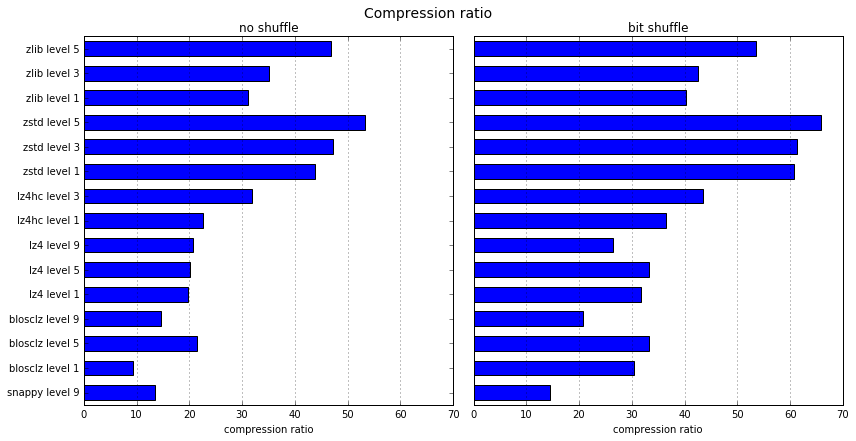

In [49]:
ratios = compression_ratios()    
labels = ['%s level %s' % (o['cname'], o['clevel'])
          for o in compression_configs]

fig = plt.figure(figsize=(12, len(compression_configs)*.2))
fig.suptitle('Compression ratio', fontsize=14, y=1.01)

ax = fig.add_subplot(1, 2, 1)
x = [r for r, o in zip(ratios, compression_configs) if o['shuffle'] == 0]
tl = [l for l, o in zip(labels, compression_configs) if o['shuffle'] == 0]
ax.barh(bottom=np.arange(len(x)) + .2, width=x, height=.6)
ax.set_yticks(np.arange(len(x))+.5)
ax.set_yticklabels(tl, rotation=0)
ax.set_title('no shuffle')
ax.set_xlim(0, 70)
ax.set_ylim(0, len(tl))
ax.set_xlabel('compression ratio')
ax.grid(axis='x')

ax = fig.add_subplot(1, 2, 2)
x = [r for r, o in zip(ratios, compression_configs) if o['shuffle'] == 2]
tl = [l for l, o in zip(labels, compression_configs) if o['shuffle'] == 2]
ax.barh(bottom=np.arange(len(x)) + .2, width=x, height=.6)
ax.set_yticks([])
ax.set_xlim(0, 70)
ax.set_ylim(0, len(tl))
ax.set_xlabel('compression ratio')
ax.grid(axis='x')
ax.set_title('bit shuffle')

fig.tight_layout();


In [46]:
@functools.lru_cache(maxsize=None)
def compression_decompression_times(repeat=3, number=1):
    c = list()
    d = list()
    for compression_opts in compression_configs:
        
        def compress():
            zarr.array(genotype_sample, chunks=chunks, compression='blosc', 
                       compression_opts=compression_opts)
            
        t = timeit.Timer(stmt=compress, globals=locals())
        compress_times = t.repeat(repeat=repeat, number=number)
        c.append(compress_times)
        
        z = zarr.array(genotype_sample, chunks=chunks, compression='blosc', 
                       compression_opts=compression_opts)
        
        def decompress():
            z[:]
            
        t = timeit.Timer(stmt=decompress, globals=locals())
        decompress_times = t.repeat(repeat=repeat, number=number)
        d.append(decompress_times)
        
        log(compression_opts, compress_times, decompress_times)
        
    return c, d
    

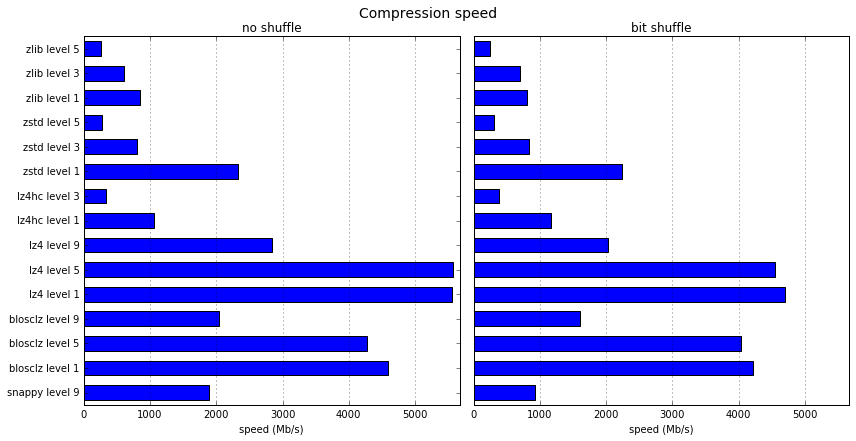

In [50]:
co_t, de_t = compression_decompression_times()

fig = plt.figure(figsize=(12, 6))
fig.suptitle('Compression speed', fontsize=14, y=1.01)

xlim = (0, np.max((nbytes / 1000000) / np.array(co_t)) + 100)

ax = fig.add_subplot(1, 2, 1)
x = (nbytes / 1000000) / np.array([c for c, o in zip(co_t, compression_configs) if o['shuffle'] == 0])
tl = [l for l, o in zip(labels, compression_configs) if o['shuffle'] == 0]

ax.barh(bottom=np.arange(len(x)) + .2, width=x.max(axis=1), height=.6)
ax.set_yticks(np.arange(len(x))+.5)
ax.set_yticklabels(tl, rotation=0)
ax.set_title('no shuffle')
ax.set_xlim(*xlim)
ax.set_ylim(0, len(tl))
ax.set_xlabel('speed (Mb/s)')
ax.grid(axis='x')

ax = fig.add_subplot(1, 2, 2)
x = (nbytes / 1000000) / np.array([c for c, o in zip(co_t, compression_configs) if o['shuffle'] == 2])
tl = [l for l, o in zip(labels, compression_configs) if o['shuffle'] == 2]

ax.barh(bottom=np.arange(len(x)) + .2, width=x.max(axis=1), height=.6)
ax.set_yticks([])
ax.set_title('bit shuffle')
ax.set_xlim(*xlim)
ax.set_ylim(0, len(tl))
ax.set_xlabel('speed (Mb/s)')
ax.grid(axis='x')

fig.tight_layout();

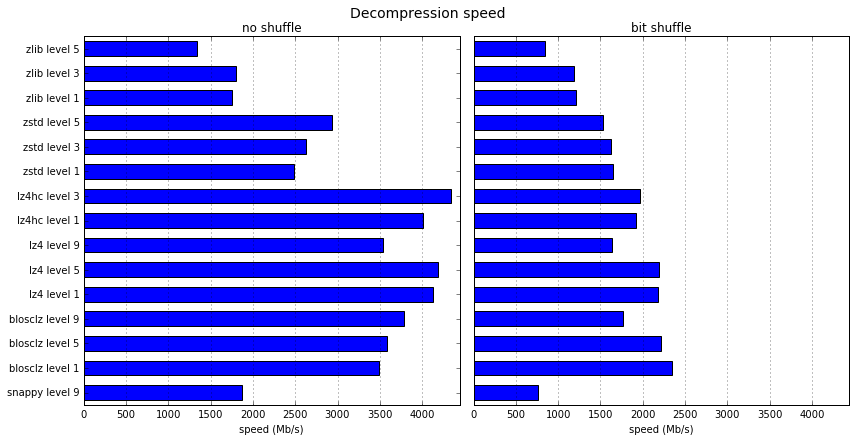

In [51]:
fig = plt.figure(figsize=(12, 6))
fig.suptitle('Decompression speed', fontsize=14, y=1.01)

xlim = (0, np.max((nbytes / 1000000) / np.array(de_t)) + 100)

ax = fig.add_subplot(1, 2, 1)
x = (nbytes / 1000000) / np.array([d for d, o in zip(de_t, compression_configs) if o['shuffle'] == 0])
tl = [l for l, o in zip(labels, compression_configs) if o['shuffle'] == 0]

ax.barh(bottom=np.arange(len(x)) + .2, width=x.max(axis=1), height=.6)
ax.set_yticks(np.arange(len(x))+.5)
ax.set_yticklabels(tl, rotation=0)
ax.set_title('no shuffle')
ax.set_xlim(*xlim)
ax.set_ylim(0, len(tl))
ax.set_xlabel('speed (Mb/s)')
ax.grid(axis='x')

ax = fig.add_subplot(1, 2, 2)
x = (nbytes / 1000000) / np.array([d for d, o in zip(de_t, compression_configs) if o['shuffle'] == 2])
tl = [l for l, o in zip(labels, compression_configs) if o['shuffle'] == 2]

ax.barh(bottom=np.arange(len(x)) + .2, width=x.max(axis=1), height=.6)
ax.set_yticks([])
ax.set_title('bit shuffle')
ax.set_xlim(*xlim)
ax.set_ylim(0, len(tl))
ax.set_xlabel('speed (Mb/s)')
ax.grid(axis='x')

fig.tight_layout();